# Imports

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import string
import re
from nltk.tokenize import word_tokenize
import nltk

In [2]:
ip = pd.read_excel("Input.xlsx")
ip.head()

,URL_ID,URL
0,blackassign0001,https://insights.blackcoffer.com/rising-it-cit...
1,blackassign0002,https://insights.blackcoffer.com/rising-it-cit...
2,blackassign0003,https://insights.blackcoffer.com/internet-dema...
3,blackassign0004,https://insights.blackcoffer.com/rise-of-cyber...
4,blackassign0005,https://insights.blackcoffer.com/ott-platform-...


# Complete Web Scraping. Most of the Error Solved with great accuracy

In [3]:
count = 0
for i in ip['URL']:
    web = requests.get(i)
    soup = BeautifulSoup(web.content, "html.parser")
    title = soup.title.string
    
    if(soup.title.string == "Page not found - Blackcoffer Insights" ):
        print(f"can't get page of {count}, {i}")
        file = open(f"Txt-Output\\{ip['URL_ID'][count]}.txt", 'a')
        file.write(f"can't get page of index {i} \n\n\n")
        file.close()
        pass   
    
    try:
        article = soup.find("div", class_ = 'td-post-content tagdiv-type')
        article=article.text.replace('\xa0',"  ").replace('\n',"  ").replace('\u202f',"  ")
        file = open(f"Txt-Output\\{ip['URL_ID'][count]}.txt", 'a')
        file.write(str(article))
        file.close()
        
    except AttributeError:
        article = soup.find_all("p")
        start = 17
        end = len(article)-2
        while start<end:
            file = open(f"Txt-Output\\{ip['URL_ID'][count]}.txt", 'a')
            file.write(str(article[start].text))
            start+=1
        file.close()
        
    except UnicodeEncodeError:
        file.write("Unable to solve Unicode Error")
        file.close()
        
    count+=1
    

can't get page of 35, https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/
can't get page of 48, https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/



# Removing punctuations and stop words


In [4]:

stopwords_files =  [r"StopWords\StopWords_Auditor.txt", r"StopWords\StopWords_Currencies.txt", r"StopWords\StopWords_DatesandNumbers.txt", r"StopWords\StopWords_Generic.txt", r"StopWords\StopWords_GenericLong.txt", r"StopWords\StopWords_Geographic.txt", r"StopWords\StopWords_Names.txt"]

def remove_stopwords(text_file, stopwords_files):
    # Read the stopwords from the files and combine them into a set
    stop_words = set()
    for file in stopwords_files:
        with open(file, 'r') as f:
            stop_words.update(f.read().splitlines())

    # Now read the text file, remove the stopwords, and write the result to a new file
    with open(text_file, 'r') as f:
        lines = f.readlines()

    with open(text_file, 'w') as f:
        for line in lines:
            line = line.lower()
            #line = line.translate(str.maketrans("","", string.punctuation))
            words = line.split()
            cleaned_line = ' '.join(word for word in words if word not in stop_words)
            f.write(cleaned_line + '\n')
            
            
for i in ip['URL_ID']:
    text_file = fr"Txt-Output\{i}.txt" 
    remove_stopwords(text_file, stopwords_files)
    


# Creating list of positive and negative words with given txt files

In [5]:
positive = []
negative = []
with open(r"MasterDictionary\positive-words.txt", 'r') as f:
    for a in f:
        global positive
        positive.append(a.lower().replace("\n", ''))
with open(r"MasterDictionary\negative-words.txt", 'r') as f:
    for a in f:
        global negative
        negative.append(a.lower().replace("\n", ''))

# creating function of all mentioned variable

In [6]:
#positive score
def ps(tokenize_text):
    positive_score=0
    for i in tokenize_text:
          if(i.lower() in positive):
            positive_score+=1
    return positive_score


#negative score
def ns(tokenize_text, negative):
    negative_score = 0
    for i in tokenize_text:
        if i.lower() in negative:
            negative_score += 1
    return negative_score


#Polarity Score = (Positive Score – Negative Score)/ ((Positive Score + Negative Score) + 0.000001)
def pol_s(positive_score, negative_score):
    Polarity_Score=(positive_score-negative_score)/((positive_score+negative_score)+ 0.000001)
    return Polarity_Score


#Subjectivity Score = (Positive Score + Negative Score)/ ((Total Words after cleaning) + 0.000001)
def sub_s(positive_score, negative_score, tokenize_text):
    subjectiivity_score=(positive_score-negative_score)/((len(tokenize_text))+ 0.000001)
    return subjectiivity_score


#average sentence length
def avg_s_len(text):
        sentences = text.split(".") #split the text into a list of sentences.
        words = text.split(" ") #split the input text into a list of separate words
        if(sentences[len(sentences)-1]==""): #if the last value in sentences is an empty string
            average_sentence_length = len(words) / len(sentences)-1
        else:
            average_sentence_length = len(words) / len(sentences)
        return average_sentence_length

    
#complex words percentage
def calculate_complex_words_percentage(filename):
    # Define a function to count syllables in a word
    def count_syllables(word):
        vowels = 'aeiouy'
        word = word.lower()
        count = 0
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                count += 1
        if word.endswith('e'):
            count -= 1
        if word.endswith('le'):
            count += 1
        if count == 0:
            count += 1
        return count
    # Initialize counters
    total_words = 0
    complex_words = 0
    # Open the file and read the content
    with open(filename, 'r') as f:
        for line in f:
            words = line.split()
            total_words += len(words)
            complex_words += sum(1 for word in words if count_syllables(word) > 2)
    # Calculate and return the percentage of complex words
    ans = (complex_words / total_words) * 100 if total_words > 0 else 0
    return ans


#Fog Index = 0.4 * (Average Sentence Length + Percentage of Complex words)
def fg_i(avg_len, ans):
    
    Fog_Index = 0.4 * (avg_len + ans)
    return Fog_Index


#average words per sentence
def calculate_average_words_per_sentence(filename):
    # Initialize counters
    total_words = 0
    total_sentences = 0

    # Open the file and read the content
    with open(filename, 'r') as f:
        for line in f:
            sentences = line.split('.')
            total_sentences += len(sentences)
            words = line.split()
            total_words += len(words)

    # Calculate and return the average number of words per sentence
    return total_words / total_sentences if total_sentences > 0 else 0


#count of complex words
def count_complex_words(filename):
    # Initialize counter
    complex_words = 0

    # Open the file and read the content
    with open(filename, 'r') as f:
        for line in f:
            words = line.split()
            complex_words += sum(1 for word in words if len(word) > 6)

    # Return the number of complex words
    return complex_words


#word count
def wrd_cnt(tokenize_text):
    word_count=len(tokenize_text)
    return word_count


#syllables count
def count_syllables(word):
    vowels=['a','e','i','o','u']
    c=0
    for i in tokenize_text:
        x=re.compile('[es|ed]$')
        if x.match(i.lower()):
            c+=0
        else:
            for j in i:
                if(j.lower() in vowels ):
                    c+=1
    return c


#count of pronouns
def cnt_pronoun(tokenize_text):
    pronouns=['i','we','my','ours','us' ]
    c=0
    for i in tokenize_text:
          if i.lower() in pronouns:
            c+=1
    personal_pronouns=c
    return personal_pronouns 


#average word length
def avg_word_len(tokenize_text):
    count=0
    for i in tokenize_text:
        for j in i:
            count+=1
    avg_word_length=count/len(tokenize_text)
    return avg_word_length

# Saving all the variables directly into EXCEL Output file

In [7]:
op = pd.read_excel("Output Data Structure.xlsx")

#creating list to store variables
psl, pol_s_l, nsl, sub_s_l, avg_s_len_l, complex_avg = [],[],[],[],[],[]
fg_i_l, awps, ccw, wrd_cnt_l, cs, cnt_p_l, a_w_l = [],[],[],[],[],[],[]

count = 0
for o in op['URL_ID']:
    tokenize_text = []
    with open(fr"Txt-Output\{o}.txt", 'r') as f:
        txt_list = f.readlines()
        for t in txt_list:
            tokenize_text+=(word_tokenize(t))

    text_file = open(fr"Txt-Output\{o}.txt", "r")
    data = text_file.read()
    text_file.close()
    
    #using functions and appending into list
    psl.append(ps(tokenize_text))
    nsl.append(ns(tokenize_text, negative))
    pol_s_l.append(pol_s(ps(tokenize_text), ns(tokenize_text, negative)))
    sub_s_l.append(sub_s(ps(tokenize_text), ns(tokenize_text, negative), tokenize_text))
    avg_s_len_l.append(avg_s_len(data))
    complex_avg.append(calculate_complex_words_percentage(fr"Txt-Output\{o}.txt"))
    fg_i_l.append(fg_i(avg_s_len(data), calculate_complex_words_percentage(fr"Txt-Output\{o}.txt")))
    awps.append(calculate_average_words_per_sentence(fr"Txt-Output\{o}.txt"))
    ccw.append(count_complex_words(fr"Txt-Output\{o}.txt"))
    wrd_cnt_l.append(wrd_cnt(tokenize_text))
    cs.append(count_syllables(data))
    cnt_p_l.append(cnt_pronoun(tokenize_text))
    a_w_l.append(avg_word_len(tokenize_text))
    
    count+=1
    
#inserting variable values into excel file 
op['POSITIVE SCORE']= psl
op['NEGATIVE SCORE']= nsl
op['POLARITY SCORE']=pol_s_l
op['SUBJECTIVITY SCORE'] = sub_s_l
op['AVG SENTENCE LENGTH']=avg_s_len_l
op['PERCENTAGE OF COMPLEX WORDS']=complex_avg
op['FOG INDEX']=fg_i_l
op['AVG NUMBER OF WORDS PER SENTENCE']=awps
op['COMPLEX WORD COUNT']=ccw
op['WORD COUNT']=wrd_cnt_l
op['SYLLABLE PER WORD']=cs
op['PERSONAL PRONOUNS']=cnt_p_l
op['AVG WORD LENGTH']=a_w_l

# Visualization of each variable

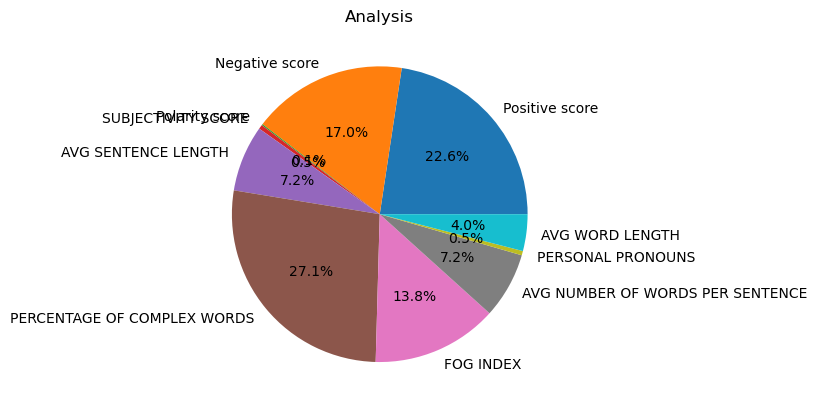

In [48]:
import matplotlib.pyplot as plt
 
a = (op['POSITIVE SCORE']).sum()
b = (op['NEGATIVE SCORE']).sum()
c = (op['POLARITY SCORE']).sum()
d = (op['SUBJECTIVITY SCORE']>=0).sum()
e = (op['AVG SENTENCE LENGTH']).sum()
f= (op['PERCENTAGE OF COMPLEX WORDS']).sum()
g = (op['FOG INDEX']).sum()
h = (op['AVG NUMBER OF WORDS PER SENTENCE']).sum()
l = (op['PERSONAL PRONOUNS']).sum()
m = (op['AVG WORD LENGTH']).sum()

#neglecting count of Complex word, syllable and word : since they have largest sum among all
plt.pie([a,b,c,d,e,f,g,h,l,m], labels=['Positive score', 'Negative score','Polarity score', 'SUBJECTIVITY SCORE', 'AVG SENTENCE LENGTH','PERCENTAGE OF COMPLEX WORDS','FOG INDEX','AVG NUMBER OF WORDS PER SENTENCE','PERSONAL PRONOUNS','AVG WORD LENGTH'], autopct='%1.1f%%')
plt.title('Analysis')
plt.show()

# Saving Output excel file 

In [9]:
op.to_excel("Output Data Structure.xlsx")
op

,Unnamed: 0,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,0,blackassign0001,https://insights.blackcoffer.com/rising-it-cit...,33,6,0.692308,0.038028,7.278481,28.695652,14.389653,7.278481,268,710,1422,0,5.469014
1,1,blackassign0002,https://insights.blackcoffer.com/rising-it-cit...,60,31,0.318681,0.028074,9.817073,42.360248,20.870929,9.817073,502,1033,2297,2,5.998064
2,2,blackassign0003,https://insights.blackcoffer.com/internet-dema...,38,24,0.225806,0.017880,11.070175,55.467512,26.615075,11.070175,463,783,1982,0,6.867178
3,3,blackassign0004,https://insights.blackcoffer.com/rise-of-cyber...,38,75,-0.327434,-0.047619,11.865385,52.350081,25.686186,11.865385,446,777,1846,0,6.603604
4,4,blackassign0005,https://insights.blackcoffer.com/ott-platform-...,22,8,0.466667,0.030769,9.350000,40.641711,19.996684,9.350000,238,455,1037,0,6.356044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,blackassign0096,https://insights.blackcoffer.com/what-is-the-r...,29,57,-0.325581,-0.041056,11.075472,42.759796,21.534107,11.075472,360,682,1596,0,6.400293
96,96,blackassign0097,https://insights.blackcoffer.com/impact-of-cov...,25,35,-0.166667,-0.017065,11.743590,30.786026,17.011846,11.743590,232,586,1170,1,5.382253
97,97,blackassign0098,https://insights.blackcoffer.com/contribution-...,5,3,0.250000,0.007018,9.520000,38.655462,19.270185,9.520000,133,285,609,0,6.178947
98,98,blackassign0099,https://insights.blackcoffer.com/how-covid-19-...,18,2,0.800000,0.045326,9.400000,32.624113,16.809645,9.400000,149,353,707,1,5.691218


In [10]:
# file = open(r"L:\blackcoffer\Txt-Output\blackassign0001.txt", 'r').read()
# file = file.lower()
# file = file.translate(str.maketrans("","", string.punctuation))
# file

In [11]:
# stopwords_files =  [r"L:\blackcoffer\StopWords\StopWords_Auditor.txt", r"L:\blackcoffer\StopWords\StopWords_Currencies.txt", r"L:\blackcoffer\StopWords\StopWords_DatesandNumbers.txt", r"L:\blackcoffer\StopWords\StopWords_Generic.txt", r"L:\blackcoffer\StopWords\StopWords_GenericLong.txt", r"L:\blackcoffer\StopWords\StopWords_Geographic.txt", r"L:\blackcoffer\StopWords\StopWords_Names.txt"]

# def remove_stopwords(text_file, stopwords_files):
#     # Read the stopwords from the files and combine them into a set
#     stop_words = set()
#     for file in stopwords_files:
#         with open(file, 'r') as f:
#             stop_words.update(f.read().splitlines())

#     # Now read the text file, remove the stopwords, and write the result to a new file
#     with open(text_file, 'r') as f:
#         lines = f.readlines()

#     with open('cleaned_file.txt', 'w') as f:
#         for line in lines:
#             words = line.split()
#             cleaned_line = ' '.join(word for word in words if word not in stop_words)
#             f.write(cleaned_line + '\n')

# # Call the function with your files
# remove_stopwords(r"L:\blackcoffer\Txt-Output\blackassign0001.txt", stopwords_files)


In [12]:

#nltk.download('punkt')
# tokenize_text = []
# with open(r"L:\blackcoffer\Txt-Output\blackassign0001.txt", 'r') as f:
#         txt_list = f.readlines()
#         for i in txt_list:
#             tokenize_text+=(word_tokenize(i))
# #tokenize_text

In [13]:


# Call the function with your file
#percentage = calculate_complex_words_percentage('file1.txt')
#print(f"The percentage of complex words is {percentage}%")


In [14]:

# Call the function with your file
# average = calculate_average_words_per_sentence('file1.txt')
# print(f"The average number of words per sentence is {average}")


In [15]:

# Call the function with your file
# complex_words = count_complex_words('file1.txt')
# print(f"The number of complex words is {complex_words}")
